# Import and Costants

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import models
import numpy as np
import pandas as pd
from tensorflow import keras
import os
import shutil
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import imutils
from tqdm.auto import tqdm
from google.colab import drive
from gensim.models import Word2Vec
from collections import Counter
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization


# Connection to Google Drive

In [ ]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
%run /content/gdrive/Shareddrives/CyberBullyingClassification/utilities.ipynb

# Dataset loading
We load the dataset and prepare it for the training.

In [ ]:
train_ds, val_ds, test_ds = load_data_splits()

In [ ]:
x_train, y_train, x_val, y_val, x_test, y_test = get_data_and_labels(train_ds, val_ds, test_ds)

In [ ]:
MAX_LENGTH = 350 # max len of representation of a tweet
MAX_WORDS = 25000 # max size of vocabulary

vectorizer = TextVectorization(output_mode = 'int', # set different output encoding
                               standardize='lower_and_strip_punctuation',
                               split="whitespace",
                               output_sequence_length = MAX_LENGTH,
                               pad_to_max_tokens=True,
                               max_tokens = MAX_WORDS,
                               ngrams=None)

We load the embedding matrices and we create the tensors to use for the training.

In [ ]:
embedding_matrix_spacy = loadObject(EMBEDDINGS_PATH + "/embedding_matrix_spacy")
embedding_matrix_custom = loadObject(EMBEDDINGS_PATH + "/embedding_matrix_customed")

In [ ]:
vectorizer.adapt(x_train)

x_train = vectorizer(np.array([[s] for s in x_train])).numpy()
x_val = vectorizer(np.array([[s] for s in x_val])).numpy()
x_test = vectorizer(np.array([[s] for s in x_test])).numpy()

y_train = np.array([[s] for s in y_train])
y_val = np.array([[s] for s in y_val])
y_test = np.array([[s] for s in y_test])

In [ ]:
x_train = tf.convert_to_tensor(x_train)
x_val = tf.convert_to_tensor(x_val)
x_test = tf.convert_to_tensor(x_test)

y_train = tf.convert_to_tensor(y_train)
y_val = tf.convert_to_tensor(y_val)
y_test = tf.convert_to_tensor(y_test)

#LSTM trained with Spacy embeddings

## 64 LSTM, 30 Dense neurons
We first tried with a simple model.

In [ ]:
num_tokens = embedding_matrix_spacy.shape[0]
embedding_dim = embedding_matrix_spacy.shape[1]

In [ ]:
embedding_layer = layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix_spacy),
    input_length = MAX_LENGTH,
    trainable=False,
)

model = keras.Sequential(name = "LSTM64_spacy")
model.add(embedding_layer)
model.add(layers.Bidirectional(layers.LSTM(64)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(30,activation = "relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(CLASSES),activation = "softmax"))

model = compile_model(model, loss="sparse_categorical_crossentropy")
model.summary()

Model: "LSTM64_spacy"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 350, 300)          8084700   
                                                                 
 bidirectional_6 (Bidirectio  (None, 128)              186880    
 nal)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 30)                3870      
                                                                 
 dropout_13 (Dropout)        (None, 30)                0         
                                                                 
 dense_13 (Dense)            (None, 6)                 186       
                                                      

Epoch 1/50
109/109 [==============================] - ETA: 0s - loss: 1.6707 - accuracy: 0.3064
Epoch 1: val_loss improved from inf to 1.35360, saving model to model/LSTM64_spacy.h5
109/109 [==============================] - 15s 116ms/step - loss: 1.6707 - accuracy: 0.3064 - val_loss: 1.3536 - val_accuracy: 0.5509
Epoch 2/50
109/109 [==============================] - ETA: 0s - loss: 1.2595 - accuracy: 0.5396
Epoch 2: val_loss improved from 1.35360 to 0.90700, saving model to model/LSTM64_spacy.h5
109/109 [==============================] - 12s 111ms/step - loss: 1.2595 - accuracy: 0.5396 - val_loss: 0.9070 - val_accuracy: 0.6973
Epoch 3/50
109/109 [==============================] - ETA: 0s - loss: 1.0265 - accuracy: 0.6422
Epoch 3: val_loss improved from 0.90700 to 0.81139, saving model to model/LSTM64_spacy.h5
109/109 [==============================] - 12s 114ms/step - loss: 1.0265 - accuracy: 0.6422 - val_loss: 0.8114 - val_accuracy: 0.7221
Epoch 4/50
109/109 [========================

INFO:tensorflow:Assets written to: ram://10694def-9622-441d-ba39-40cad7f5076d/assets


INFO:tensorflow:Assets written to: ram://10694def-9622-441d-ba39-40cad7f5076d/assets


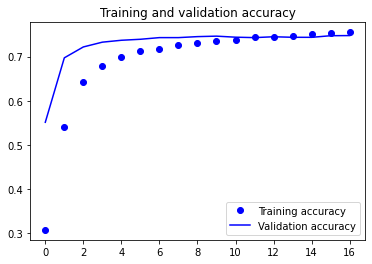

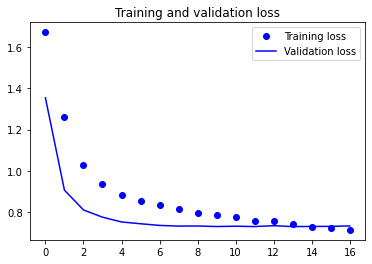

In [ ]:
model, history = run_model(model, model.name, x_train, y_train, x_val, y_val, 50, patience=3, monitor='val_loss')
plot_accuracy_and_loss_history(history)

In [ ]:
evaluate_model(model, x_test, y_test)

262/262 [==============================] - 4s 13ms/step - loss: 0.4964 - accuracy: 0.8165
Loss on test set: 0.49644821882247925
Accuracy on test set: 0.8165071606636047
                     precision    recall  f1-score   support

                age     0.9262    0.9731    0.9490      1560
          ethnicity     0.9670    0.9701    0.9685      1570
             gender     0.8733    0.8369    0.8547      1441
           religion     0.9406    0.9483    0.9444      1585
other_cyberbullying     0.5219    0.1345    0.2139       974
  not_cyberbullying     0.4932    0.7683    0.6008      1230

           accuracy                         0.8165      8360
          macro avg     0.7870    0.7719    0.7552      8360
       weighted avg     0.8166    0.8165    0.7987      8360



262/262 [==============================] - 3s 11ms/step


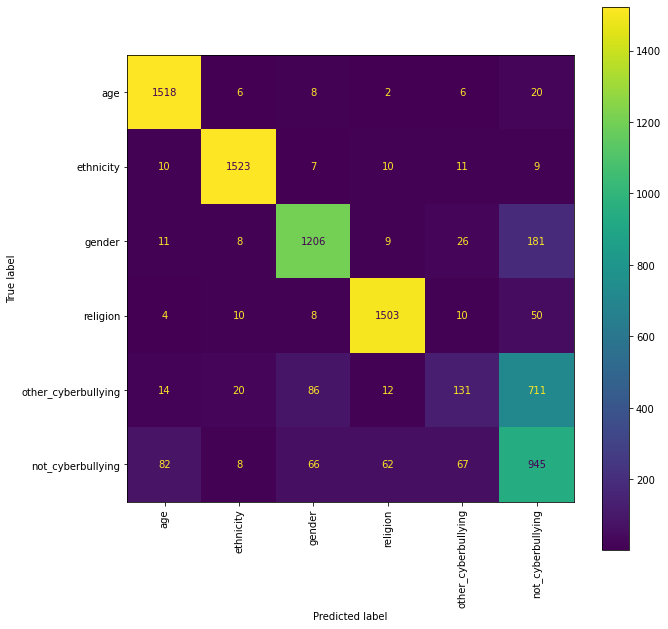

In [ ]:
plot_confusionmatrix(model, x_test, y_test)

## 512 LSTM, 128 Dense neurons

In [ ]:
num_tokens = embedding_matrix_spacy.shape[0]
embedding_dim = embedding_matrix_spacy.shape[1]

In [ ]:
embedding_layer = layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix_spacy),
    input_length = MAX_LENGTH,
    trainable=False,
)

model = keras.Sequential(name = "LSTM512_spacy")
model.add(embedding_layer)
model.add(layers.Bidirectional(layers.LSTM(512)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128,activation = "relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(CLASSES),activation = "softmax"))

model = compile_model(model, loss="sparse_categorical_crossentropy", learning_rate=0.0001)
model.summary()

Model: "LSTM512_spacy"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 350, 300)          8084700   
                                                                 
 bidirectional_8 (Bidirectio  (None, 1024)             3330048   
 nal)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 1024)              0         
                                                                 
 dense_16 (Dense)            (None, 128)               131200    
                                                                 
 dropout_17 (Dropout)        (None, 128)               0         
                                                                 
 dense_17 (Dense)            (None, 6)                 774       
                                                     

Epoch 1/50
109/109 [==============================] - ETA: 0s - loss: 1.4702 - accuracy: 0.4366
Epoch 1: val_loss improved from inf to 1.04185, saving model to model/LSTM512_spacy.h5
109/109 [==============================] - 50s 438ms/step - loss: 1.4702 - accuracy: 0.4366 - val_loss: 1.0418 - val_accuracy: 0.6499
Epoch 2/50
109/109 [==============================] - ETA: 0s - loss: 0.9879 - accuracy: 0.6597
Epoch 2: val_loss improved from 1.04185 to 0.82249, saving model to model/LSTM512_spacy.h5
109/109 [==============================] - 48s 438ms/step - loss: 0.9879 - accuracy: 0.6597 - val_loss: 0.8225 - val_accuracy: 0.7196
Epoch 3/50
109/109 [==============================] - ETA: 0s - loss: 0.8539 - accuracy: 0.7111
Epoch 3: val_loss improved from 0.82249 to 0.77629, saving model to model/LSTM512_spacy.h5
109/109 [==============================] - 47s 428ms/step - loss: 0.8539 - accuracy: 0.7111 - val_loss: 0.7763 - val_accuracy: 0.7383
Epoch 4/50
109/109 [=====================

INFO:tensorflow:Assets written to: ram://f71c3fd8-c2f1-44e6-afc2-b3ace9b42004/assets


INFO:tensorflow:Assets written to: ram://f71c3fd8-c2f1-44e6-afc2-b3ace9b42004/assets


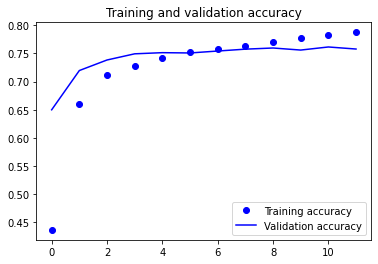

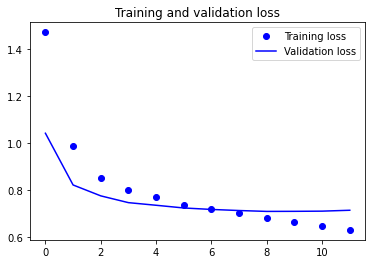

In [ ]:
model, history = run_model(model, model.name, x_train, y_train, x_val, y_val, 50, patience=3, monitor='val_loss')
plot_accuracy_and_loss_history(history)

In [ ]:
evaluate_model(model, x_test, y_test)

262/262 [==============================] - 11s 40ms/step - loss: 0.4688 - accuracy: 0.8327
Loss on test set: 0.4687979519367218
Accuracy on test set: 0.8326554894447327
                     precision    recall  f1-score   support

                age     0.9406    0.9641    0.9522      1560
          ethnicity     0.9651    0.9675    0.9663      1570
             gender     0.8521    0.8598    0.8560      1441
           religion     0.9456    0.9432    0.9444      1585
other_cyberbullying     0.5278    0.5452    0.5364       974
  not_cyberbullying     0.5873    0.5472    0.5665      1230

           accuracy                         0.8327      8360
          macro avg     0.8031    0.8045    0.8036      8360
       weighted avg     0.8308    0.8327    0.8316      8360



262/262 [==============================] - 10s 36ms/step


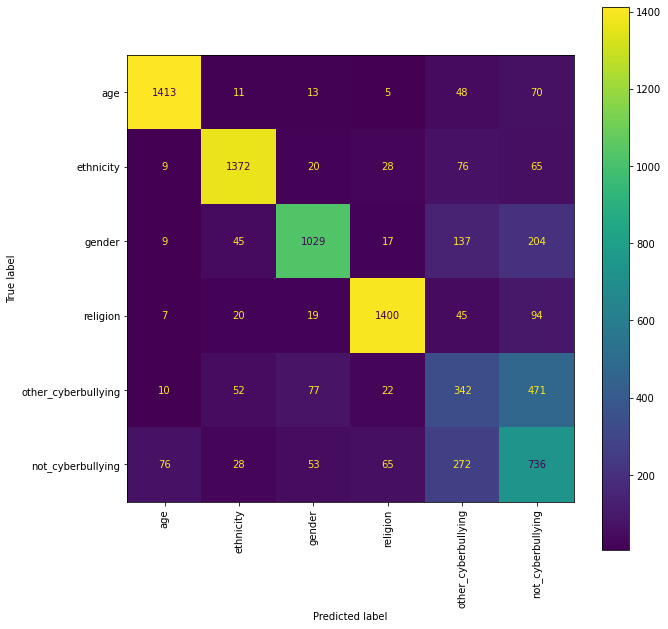

In [ ]:
plot_confusionmatrix(model, x_test, y_test)

## 512 LSTM, 128 Dense neurons, reduced Dropout

In [ ]:
num_tokens = embedding_matrix_spacy.shape[0]
embedding_dim = embedding_matrix_spacy.shape[1]

In [ ]:
embedding_layer = layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix_spacy),
    input_length = MAX_LENGTH,
    trainable=False,
)

model = keras.Sequential(name = "LSTM512_Dropout_02_spacy")
model.add(embedding_layer)
model.add(layers.Bidirectional(layers.LSTM(512)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128,activation = "relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(len(CLASSES),activation = "softmax"))

model = compile_model(model, loss="sparse_categorical_crossentropy", learning_rate=0.0001)
model.summary()

Model: "LSTM512_Dropout_02_spacy"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 350, 300)          8084700   
                                                                 
 bidirectional_10 (Bidirecti  (None, 1024)             3330048   
 onal)                                                           
                                                                 
 dropout_20 (Dropout)        (None, 1024)              0         
                                                                 
 dense_20 (Dense)            (None, 128)               131200    
                                                                 
 dropout_21 (Dropout)        (None, 128)               0         
                                                                 
 dense_21 (Dense)            (None, 6)                 774       
                                          

Epoch 1/50
109/109 [==============================] - ETA: 0s - loss: 1.2175 - accuracy: 0.5543
Epoch 1: val_loss improved from inf to 0.86947, saving model to model/LSTM512_Dropout_02_spacy.h5
109/109 [==============================] - 50s 435ms/step - loss: 1.2175 - accuracy: 0.5543 - val_loss: 0.8695 - val_accuracy: 0.6909
Epoch 2/50
109/109 [==============================] - ETA: 0s - loss: 0.8030 - accuracy: 0.7251
Epoch 2: val_loss improved from 0.86947 to 0.77253, saving model to model/LSTM512_Dropout_02_spacy.h5
109/109 [==============================] - 48s 437ms/step - loss: 0.8030 - accuracy: 0.7251 - val_loss: 0.7725 - val_accuracy: 0.7400
Epoch 3/50
109/109 [==============================] - ETA: 0s - loss: 0.7293 - accuracy: 0.7528
Epoch 3: val_loss improved from 0.77253 to 0.75047, saving model to model/LSTM512_Dropout_02_spacy.h5
109/109 [==============================] - 47s 430ms/step - loss: 0.7293 - accuracy: 0.7528 - val_loss: 0.7505 - val_accuracy: 0.7456
Epoch 4/

INFO:tensorflow:Assets written to: ram://ffab7a25-797b-4096-b3d2-144c14c0e4c0/assets


INFO:tensorflow:Assets written to: ram://ffab7a25-797b-4096-b3d2-144c14c0e4c0/assets


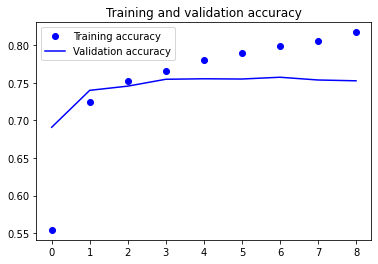

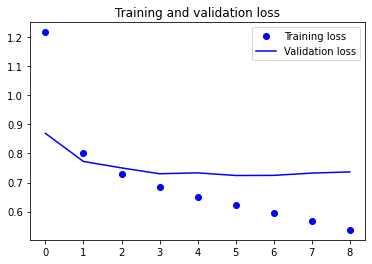

In [ ]:
model, history = run_model(model, model.name, x_train, y_train, x_val, y_val, 50, patience=3, monitor='val_loss')
plot_accuracy_and_loss_history(history)

In [ ]:
evaluate_model(model, x_test, y_test)

262/262 [==============================] - 11s 40ms/step - loss: 0.4839 - accuracy: 0.8275
Loss on test set: 0.4839290678501129
Accuracy on test set: 0.8275119662284851
                     precision    recall  f1-score   support

                age     0.9436    0.9538    0.9487      1560
          ethnicity     0.9805    0.9586    0.9694      1570
             gender     0.8517    0.8487    0.8502      1441
           religion     0.9469    0.9331    0.9399      1585
other_cyberbullying     0.5545    0.4230    0.4799       974
  not_cyberbullying     0.5382    0.6593    0.5926      1230

           accuracy                         0.8275      8360
          macro avg     0.8025    0.7961    0.7968      8360
       weighted avg     0.8303    0.8275    0.8269      8360



262/262 [==============================] - 10s 37ms/step


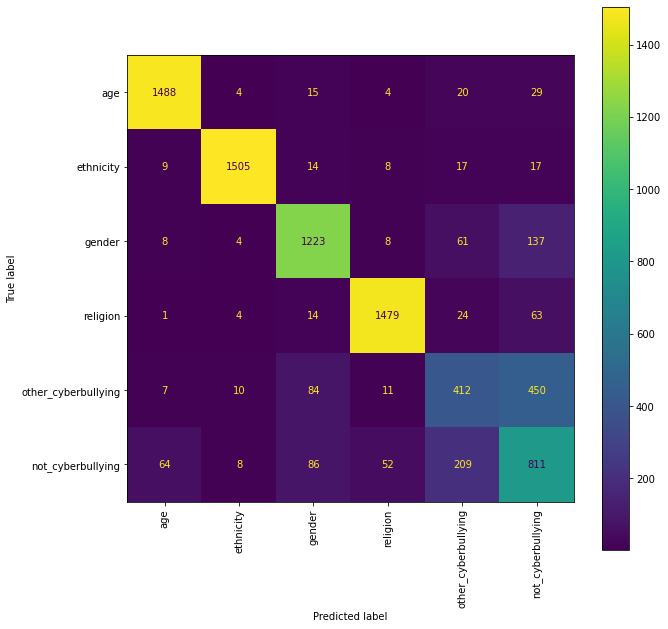

In [ ]:
plot_confusionmatrix(model, x_test, y_test)

#LSTM trained with Custom embeddings

## 30 LSTM, 30 Dense Neurons

In [ ]:
num_tokens = embedding_matrix_custom.shape[0]
embedding_dim = embedding_matrix_custom.shape[1]

In [ ]:
embedding_layer = layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix_custom),
    input_length = MAX_LENGTH,
    trainable=False,
)

model = keras.Sequential(name = "LSTM64_custom")
model.add(embedding_layer)
model.add(layers.Bidirectional(layers.LSTM(64)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(30,activation = "relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(CLASSES),activation = "softmax"))

model = compile_model(model, loss="sparse_categorical_crossentropy",learning_rate=0.0001)
model.summary()

Model: "LSTM64_custom"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 350, 50)           1347450   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              58880     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 30)                3870      
                                                                 
 dropout_1 (Dropout)         (None, 30)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 186       
                                                     

Epoch 1/50
109/109 [==============================] - ETA: 0s - loss: 1.7321 - accuracy: 0.3005
Epoch 1: val_loss improved from inf to 1.64873, saving model to model/LSTM64_custom.h5
109/109 [==============================] - 15s 76ms/step - loss: 1.7321 - accuracy: 0.3005 - val_loss: 1.6487 - val_accuracy: 0.6104
Epoch 2/50
109/109 [==============================] - ETA: 0s - loss: 1.4537 - accuracy: 0.5066
Epoch 2: val_loss improved from 1.64873 to 1.20982, saving model to model/LSTM64_custom.h5
109/109 [==============================] - 7s 69ms/step - loss: 1.4537 - accuracy: 0.5066 - val_loss: 1.2098 - val_accuracy: 0.6907
Epoch 3/50
109/109 [==============================] - ETA: 0s - loss: 1.1029 - accuracy: 0.6430
Epoch 3: val_loss improved from 1.20982 to 0.99218, saving model to model/LSTM64_custom.h5
109/109 [==============================] - 8s 69ms/step - loss: 1.1029 - accuracy: 0.6430 - val_loss: 0.9922 - val_accuracy: 0.7147
Epoch 4/50
109/109 [==========================

INFO:tensorflow:Assets written to: ram://3cd9ae19-ae3d-4b4f-bc70-7be3e1497da8/assets


INFO:tensorflow:Assets written to: ram://3cd9ae19-ae3d-4b4f-bc70-7be3e1497da8/assets


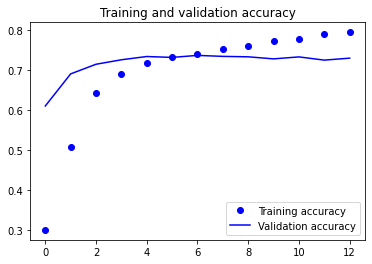

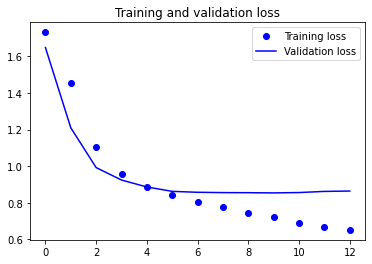

In [ ]:
model, history = run_model(model, model.name, x_train, y_train, x_val, y_val, 50, patience=3, monitor='val_loss')
plot_accuracy_and_loss_history(history)

In [ ]:
evaluate_model(model, x_test, y_test)

262/262 [==============================] - 4s 13ms/step - loss: 0.5544 - accuracy: 0.8062
Loss on test set: 0.554391622543335
Accuracy on test set: 0.8062201142311096
                     precision    recall  f1-score   support

                age     0.9538    0.9122    0.9325      1560
          ethnicity     0.9629    0.9261    0.9442      1570
             gender     0.8608    0.8452    0.8529      1441
           religion     0.9346    0.9009    0.9174      1585
other_cyberbullying     0.4523    0.4333    0.4426       974
  not_cyberbullying     0.5364    0.6463    0.5863      1230

           accuracy                         0.8062      8360
          macro avg     0.7835    0.7773    0.7793      8360
       weighted avg     0.8160    0.8062    0.8101      8360



262/262 [==============================] - 3s 11ms/step


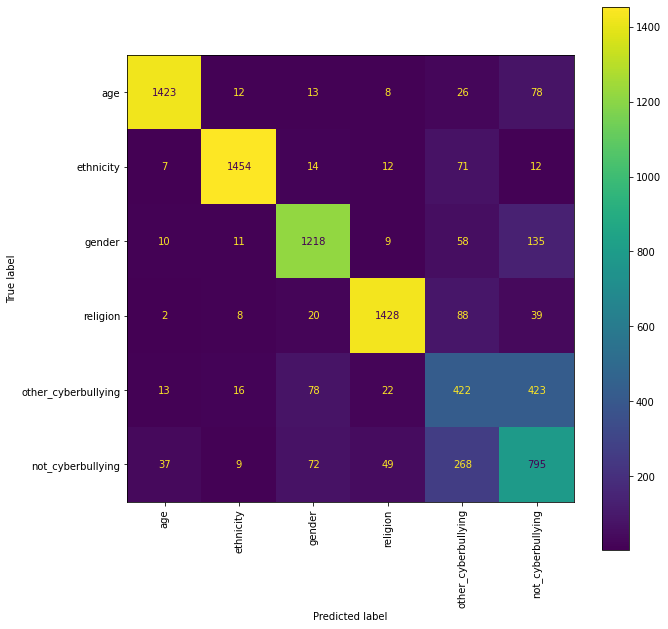

In [ ]:
plot_confusionmatrix(model, x_test, y_test)

## 512 LSTM, 128 Dense neurons

In [ ]:
num_tokens = embedding_matrix_custom.shape[0]
embedding_dim = embedding_matrix_custom.shape[1]

In [ ]:
embedding_layer = layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix_custom),
    input_length = MAX_LENGTH,
    trainable=False,
)

model = keras.Sequential(name = "LSTM512_custom")
model.add(embedding_layer)
model.add(layers.Bidirectional(layers.LSTM(512)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128,activation = "relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(CLASSES),activation = "softmax"))

model = compile_model(model, loss="sparse_categorical_crossentropy", learning_rate=0.0001)
model.summary()

Model: "LSTM512_custom"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 350, 50)           1347450   
                                                                 
 bidirectional_3 (Bidirectio  (None, 1024)             2306048   
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               131200    
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 6)                 774       
                                                    

Epoch 1/50
109/109 [==============================] - ETA: 0s - loss: 1.2775 - accuracy: 0.6081
Epoch 1: val_loss improved from inf to 0.94661, saving model to model/LSTM512_custom.h5
109/109 [==============================] - 39s 335ms/step - loss: 1.2775 - accuracy: 0.6081 - val_loss: 0.9466 - val_accuracy: 0.7263
Epoch 2/50
109/109 [==============================] - ETA: 0s - loss: 0.7180 - accuracy: 0.7687
Epoch 2: val_loss improved from 0.94661 to 0.83329, saving model to model/LSTM512_custom.h5
109/109 [==============================] - 35s 320ms/step - loss: 0.7180 - accuracy: 0.7687 - val_loss: 0.8333 - val_accuracy: 0.7367
Epoch 3/50
109/109 [==============================] - ETA: 0s - loss: 0.6061 - accuracy: 0.8043
Epoch 3: val_loss improved from 0.83329 to 0.81930, saving model to model/LSTM512_custom.h5
109/109 [==============================] - 35s 322ms/step - loss: 0.6061 - accuracy: 0.8043 - val_loss: 0.8193 - val_accuracy: 0.7419
Epoch 4/50
109/109 [==================

INFO:tensorflow:Assets written to: ram://c9a5759b-bcac-42ee-b20e-7e1dc1369e42/assets


INFO:tensorflow:Assets written to: ram://c9a5759b-bcac-42ee-b20e-7e1dc1369e42/assets


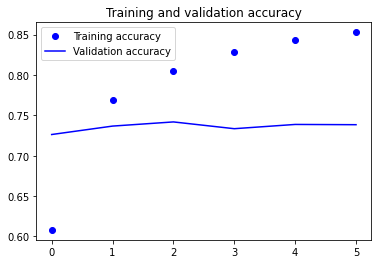

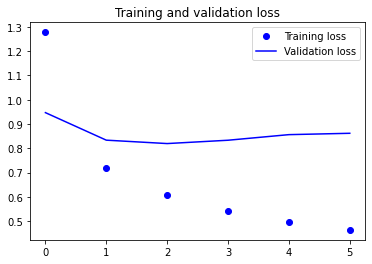

In [ ]:
model, history = run_model(model, model.name, x_train, y_train, x_val, y_val, 50, patience=3, monitor='val_loss')
plot_accuracy_and_loss_history(history)

In [ ]:
evaluate_model(model, x_test, y_test)

262/262 [==============================] - 11s 38ms/step - loss: 0.5192 - accuracy: 0.8171
Loss on test set: 0.5191687345504761
Accuracy on test set: 0.817105233669281
                     precision    recall  f1-score   support

                age     0.9459    0.9199    0.9327      1560
          ethnicity     0.9760    0.9338    0.9544      1570
             gender     0.9010    0.8397    0.8693      1441
           religion     0.9424    0.9091    0.9255      1585
other_cyberbullying     0.4548    0.5637    0.5034       974
  not_cyberbullying     0.5784    0.5935    0.5859      1230

           accuracy                         0.8171      8360
          macro avg     0.7998    0.7933    0.7952      8360
       weighted avg     0.8319    0.8171    0.8234      8360



262/262 [==============================] - 9s 35ms/step


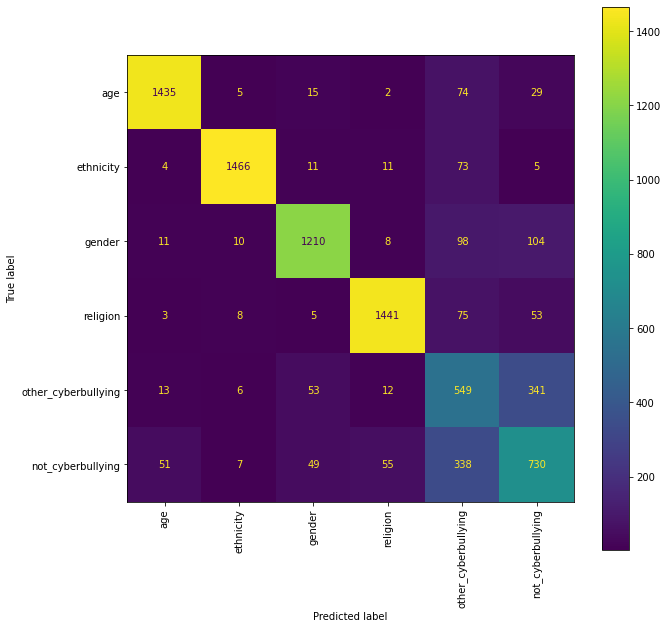

In [ ]:
plot_confusionmatrix(model, x_test, y_test)

##512 LSTM + 128 Dense neurons, reduced Dropout

In [ ]:
num_tokens = embedding_matrix_custom.shape[0]
embedding_dim = embedding_matrix_custom.shape[1]

In [ ]:
embedding_layer = layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix_custom),
    input_length = MAX_LENGTH,
    trainable=False,
)

model = keras.Sequential(name = "LSTM512_Dropout_02_custom")
model.add(embedding_layer)
model.add(layers.Bidirectional(layers.LSTM(512)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128,activation = "relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(len(CLASSES),activation = "softmax"))

model = compile_model(model, loss="sparse_categorical_crossentropy", learning_rate=0.0001)
model.summary()

Model: "LSTM512_Dropout_02_custom"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 350, 50)           1347450   
                                                                 
 bidirectional_5 (Bidirectio  (None, 1024)             2306048   
 nal)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 1024)              0         
                                                                 
 dense_10 (Dense)            (None, 128)               131200    
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 6)                 774       
                                         

Epoch 1/50
109/109 [==============================] - ETA: 0s - loss: 1.0629 - accuracy: 0.7086
Epoch 1: val_loss improved from inf to 0.85704, saving model to model/LSTM512_Dropout_02_custom.h5
109/109 [==============================] - 40s 334ms/step - loss: 1.0629 - accuracy: 0.7086 - val_loss: 0.8570 - val_accuracy: 0.7190
Epoch 2/50
109/109 [==============================] - ETA: 0s - loss: 0.5414 - accuracy: 0.8221
Epoch 2: val_loss improved from 0.85704 to 0.84572, saving model to model/LSTM512_Dropout_02_custom.h5
109/109 [==============================] - 35s 320ms/step - loss: 0.5414 - accuracy: 0.8221 - val_loss: 0.8457 - val_accuracy: 0.7243
Epoch 3/50
109/109 [==============================] - ETA: 0s - loss: 0.4498 - accuracy: 0.8519
Epoch 3: val_loss did not improve from 0.84572
109/109 [==============================] - 34s 311ms/step - loss: 0.4498 - accuracy: 0.8519 - val_loss: 0.8886 - val_accuracy: 0.7234
Epoch 4/50
109/109 [==============================] - ETA: 0s

INFO:tensorflow:Assets written to: ram://05bae0f5-030c-4d75-b2c6-25b7d884fdb8/assets


INFO:tensorflow:Assets written to: ram://05bae0f5-030c-4d75-b2c6-25b7d884fdb8/assets


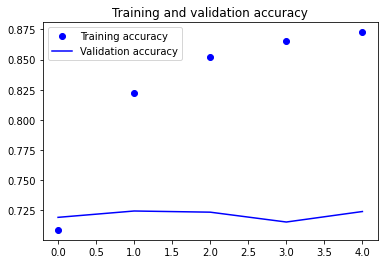

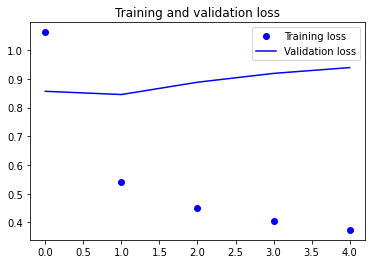

In [ ]:
model, history = run_model(model, model.name, x_train, y_train, x_val, y_val, 50, patience=3, monitor='val_loss')
plot_accuracy_and_loss_history(history)

In [ ]:
evaluate_model(model, x_test, y_test)

262/262 [==============================] - 11s 38ms/step - loss: 0.5563 - accuracy: 0.7943
Loss on test set: 0.5562819242477417
Accuracy on test set: 0.7942583560943604
                     precision    recall  f1-score   support

                age     0.9623    0.8667    0.9120      1560
          ethnicity     0.9934    0.8656    0.9251      1570
             gender     0.8664    0.8459    0.8560      1441
           religion     0.9425    0.9003    0.9209      1585
other_cyberbullying     0.3985    0.5883    0.4751       974
  not_cyberbullying     0.5782    0.5772    0.5777      1230

           accuracy                         0.7943      8360
          macro avg     0.7902    0.7740    0.7778      8360
       weighted avg     0.8257    0.7943    0.8064      8360



262/262 [==============================] - 9s 34ms/step


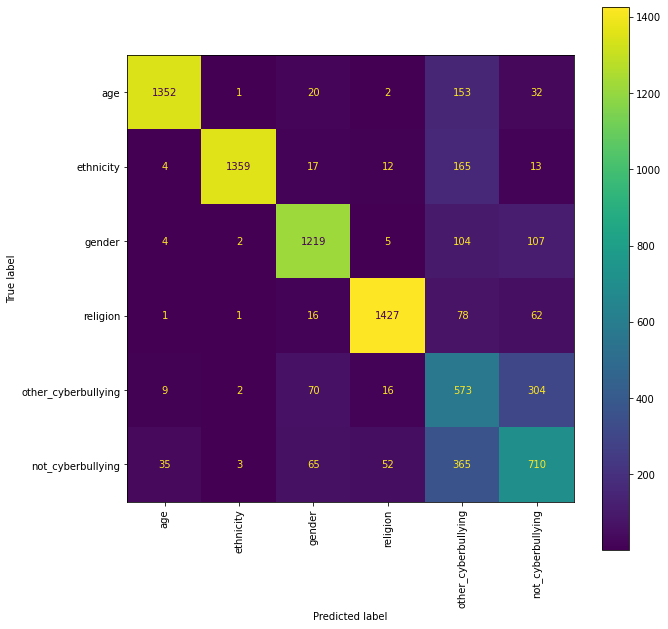

In [ ]:
plot_confusionmatrix(model, x_test, y_test)